In [ ]:
import heapq
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [ ]:
# Dijkstra
def dijkstra_with_predecessors(graph, start):
    times = {node: float('inf') for node in graph}
    times[start] = 0
    predecessors = {node: None for node in graph}
    queue = [(0, start)]

    while queue:
        current_time, node = heapq.heappop(queue)

        # Esta verificação é importante para evitar o processamento de entradas desatualizadas na fila de prioridade
        if current_time > times[node]:
            continue

        for neighbor, weight in graph[node]:
            time = current_time + weight
            if time < times[neighbor]:
                times[neighbor] = time
                predecessors[neighbor] = node
                heapq.heappush(queue, (time, neighbor))
    return times, predecessors

# RK4 (Runge-Kutta de 4ª Ordem)
def runge_kutta_4(f, y0, t0, tf, h):
    t = t0
    y = y0
    ts = [t0]
    ys = [y0]

    while t < tf:
        k1 = h * f(t, y)
        k2 = h * f(t + h/2, y + k1/2)
        k3 = h * f(t + h/2, y + k2/2)
        k4 = h * f(t + h, y + k3)
        y += (k1 + 2*k2 + 2*k3 + k4) / 6
        t += h
        ts.append(t)
        ys.append(y)
    return ts, ys , y # retorna 3 para ter o ponto final para os gráficos (puro pulo do gato)

# Modelo de contaminação
def contamination_model(t,C):
        return -0.1*t*C

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import heapq

# 1. Criar o grafo com pesos simulando tempos de contaminação (em minutos)
edges_with_weights = [
    ("Rio Santo Antônio", "Confluência", random.randint(1, 3)),
    ("Rio Cônego", "Confluência", random.randint(1, 3)),
    ("Confluência", "Olaria", random.randint(2, 5)),
    ("Olaria", "Centro", random.randint(2, 5)),
    ("Centro", "Ponte da Saudade", random.randint(3, 6)),
    ("Ponte da Saudade", "Paissandu", random.randint(3, 6)),
    ("Paissandu", "Rio Grande", random.randint(4, 7))
]

G = nx.DiGraph()
for u, v, w in edges_with_weights:
    G.add_edge(u, v, weight=w)

# 2. Implementar o algoritmo de Dijkstra
def dijkstra_with_predecessors(graph, start):
    distances = {node: float('inf') for node in graph.nodes}
    predecessors = {node: None for node in graph.nodes}
    distances[start] = 0

    queue = [(0, start)]

    while queue:
        curr_distance, curr_node = heapq.heappop(queue)

        if curr_distance > distances[curr_node]:
            continue

        for neighbor in graph.neighbors(curr_node):
            weight = graph[curr_node][neighbor]['weight']
            distance = curr_distance + weight

            if distance < distances[neighbor]:
                distances[neighbor] = distance
                predecessors[neighbor] = curr_node
                heapq.heappush(queue, (distance, neighbor))

    return distances, predecessors

# 3. Executar Dijkstra a partir de "Rio Santo Antônio"
source_node = "Rio Santo Antônio"
contamination_times, predecessors = dijkstra_with_predecessors(G, source_node)

# 4. Exibir tempos de contaminação
print(f"Tempos mínimos de contaminação a partir de '{source_node}':\n")
for node, time in contamination_times.items():
    if time == float('inf'):
        print(f"{node}: inalcançável")
    else:
        print(f"{node}: {time:.1f} min")



Tempos mínimos de contaminação a partir de 'Rio Santo Antônio':

Rio Santo Antônio: 0.0 min
Confluência: 1.0 min
Rio Cônego: inalcançável
Olaria: 5.0 min
Centro: 7.0 min
Ponte da Saudade: 11.0 min
Paissandu: 14.0 min
Rio Grande: 18.0 min


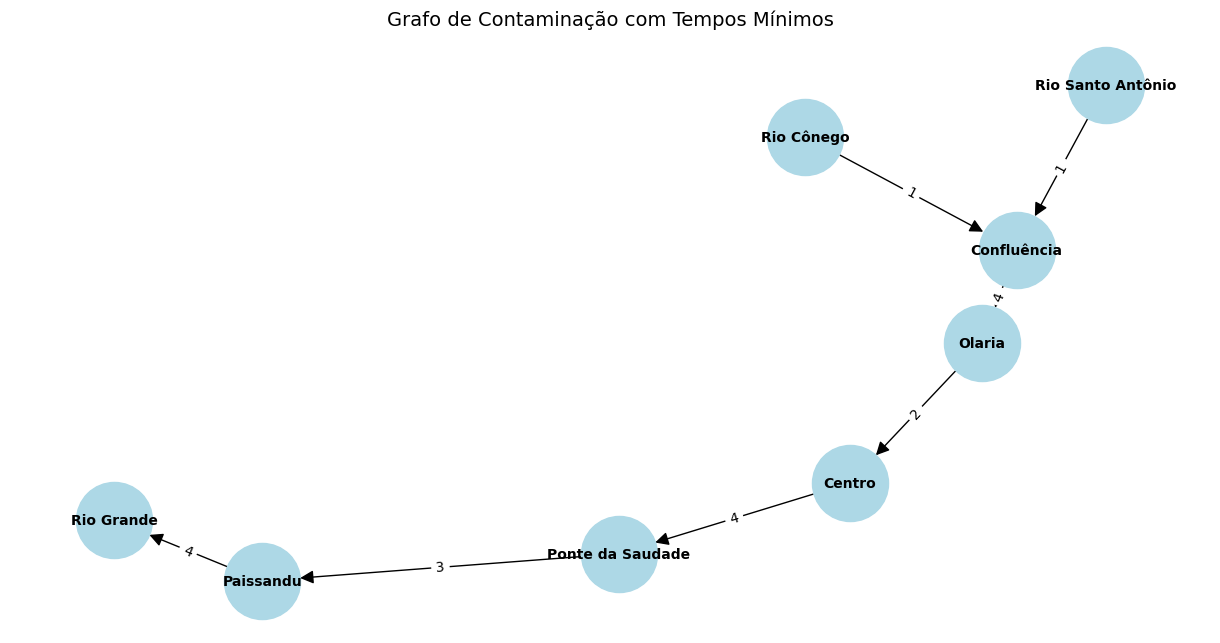

In [ ]:
# 5. Visualização do grafo com pesos
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(12, 6))
nx.draw(G, pos, with_labels=True, node_color="lightblue", node_size=3000,
        font_size=10, font_weight='bold', arrowsize=20)

edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

plt.title("Grafo de Contaminação com Tempos Mínimos", fontsize=14)
plt.axis("off")
plt.show()

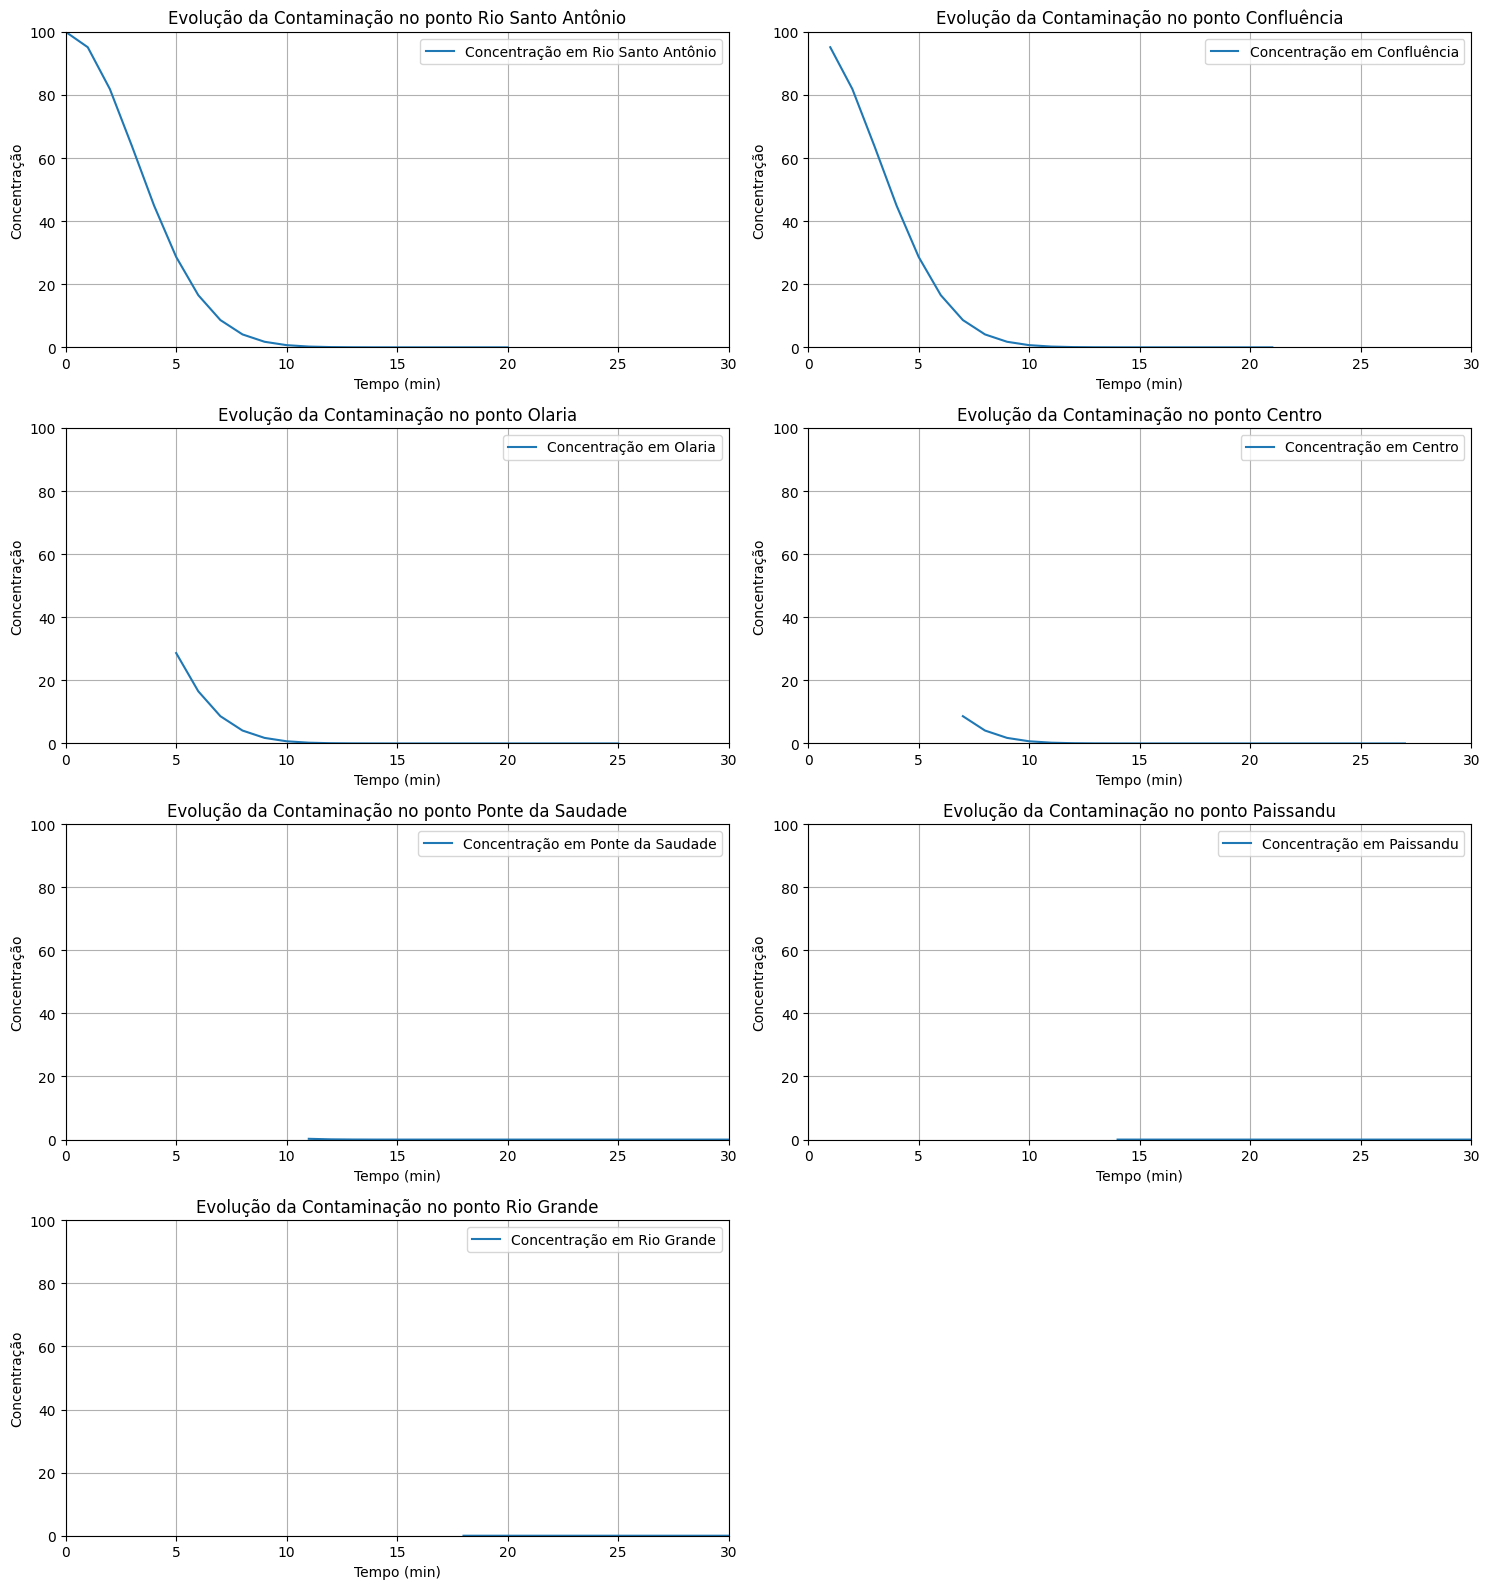

In [ ]:
contamination_times_dict, predecessors_dict = dijkstra_with_predecessors(G, source_node)

num_nodes = len(G.nodes)
num_cols = 2
num_rows = (num_nodes + num_cols - 1) // num_cols
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 4))
axs_flat = axs.flatten()

contamination_histories = {}
sorted_nodes = sorted(G.nodes, key=lambda node: contamination_times_dict[node])
plot_index = 0

for node in sorted_nodes:
    ax = axs_flat[plot_index]
    arrival_time = contamination_times_dict[node]

    if arrival_time != float('inf'):
        point = node
        predecessor = predecessors_dict[node]

        if predecessor is None:
            y0 = 100
            t0 = 0
        else:
            t0 = arrival_time
            predecessor_ts, predecessor_Cs = contamination_histories.get(predecessor, ([], []))
            y0_predecessor = 0.0
            if predecessor_ts and arrival_time >= predecessor_ts[0]:
                closest_time_index = np.argmin(np.abs(np.array(predecessor_ts) - arrival_time))
                y0_predecessor = predecessor_Cs[closest_time_index]
            y0 = y0_predecessor

        tf = t0 + 20
        h = 1

        if y0 > 1e-9:
            ts, Cs, final_y = runge_kutta_4(contamination_model, y0, t0, tf, h)
            contamination_histories[node] = (ts, Cs)

            ax.plot(ts, Cs, label=f'Concentração em {point}')
            ax.set_xlabel("Tempo (min)")
            ax.set_ylabel("Concentração")
            ax.set_title(f"Evolução da Contaminação no ponto {point}")
            ax.set_ylim(0, 100)
            ax.set_xlim(0, 30)
            ax.grid(True)
            ax.legend()
        else:
            ax.text(0.5, 0.5, f'Ponto {node} não contaminado via caminho mais curto',
                    horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
            ax.set_title(f"Evolução da Contaminação no ponto {node}")
            ax.axis('off')
            contamination_histories[node] = ([], [])
        plot_index += 1
    else:
        ax.text(0.5, 0.5, f'Ponto {node} não alcançado',
                horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.set_title(f"Evolução da Contaminação no ponto {node}")
        ax.axis('off')
        contamination_histories[node] = ([], [])

# Oculta subplots extras
for i in range(plot_index, len(axs_flat)):
    fig.delaxes(axs_flat[i])

plt.tight_layout()
plt.show()

Tentar simuliar um rio real.